## What’s This About 🤔
Welcome to *Finding NFL Winners*, a series where we dive into what it takes to predict **NFL game outcomes**. In this first part, *The Points*, we’ll explore the most common scores and examine how games are most likely to play out.

As the series unfolds, we’ll develop tools and eventually create a predictive model to answer the ultimate question: *Who’s going to win?* Let’s get started!

### Disclaimers

First, I’m relatively new to American football, with just three years of watching under my belt. While I still have plenty to learn, this fresh perspective allows me to focus solely on the numbers, free from bias.

Second, although I’ll reference Vegas odds in my analysis, I strongly discourage gambling. It’s addictive and harmful. This series is about understanding and predicting the game—not betting on it.

## CODE UTILS
---

In [18]:
from itables import show
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

# Internals
from common.data_sources import get_nfl_pbp_data, get_nfl_per_game_df, get_nfl_offensive_per_game_per_team_df
from common.graph.plotly import *
from common.math import qcut_2d

In [19]:
# Import Data
nfl_df = get_nfl_pbp_data()

Cached True
nfl_pbp_data_df


In [20]:
# Transform
nfl_per_game_df = get_nfl_per_game_df(nfl_df)
nfl_per_game_per_team_df = get_nfl_offensive_per_game_per_team_df(nfl_df)
# show(
#     nfl_df[["qtr", "time", "total_minutes", "total_minutes_rounded"]]
#     # layout={"top1": "searchPanes"}, searchPanes={"layout": "columns-3", "cascadePanes": True, "columns": [1, 6, 7]},
# )

# nfl_per_game_df.reset_index(inplace=True)
# nfl_per_game_df.groupby("season", "week").count()

## CONTENT
---

---
## Scores

According to the [NFL Rules](https://operations.nfl.com/the-rules/nfl-rulebook/): *"A team wins by having more points than its opponent after four quarters (60 minutes) or after overtime, if applicable"*. In simple terms, your offense just needs to score more points than the points your defense allow your opponent to score.

But how many points should my offense score to win, or how many points should my defense allow?

<div style="text-align: center;">
  <figure>
    <img src="article_assets/nfl_scores.webp" alt="Scores" style="max-height: 600px;">
    <figcaption>Wallpaper by shreallclark</figcaption>
  </figure>
</div>

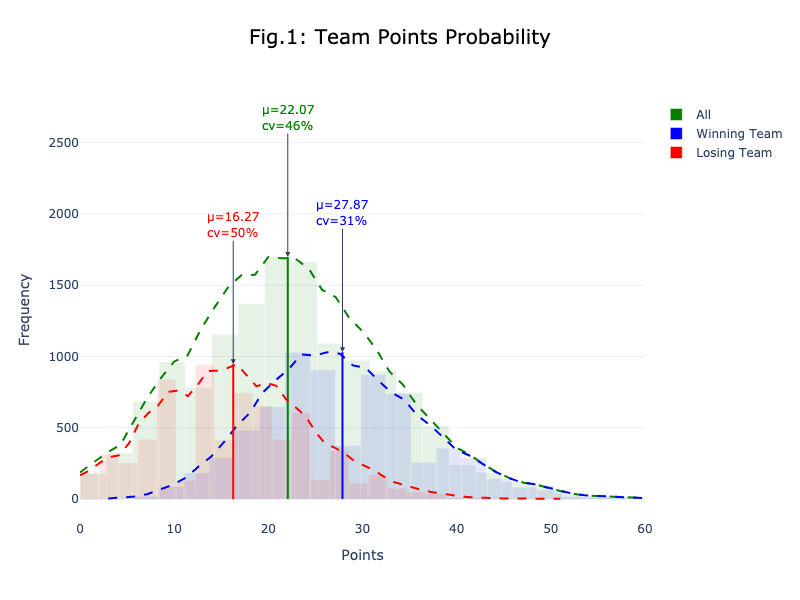

In [21]:
# Plot Histogram
# Data
score_data = nfl_per_game_per_team_df["posteam_score_post"].dropna()
winning_score_data = nfl_per_game_df["winning_team_score"].dropna()
losing_score_data = nfl_per_game_df["losing_team_score"].dropna()
# Figure
HIST_BINS = 25
fig = go.Figure()
plot_overlap_histogram(score_data, fig, bins=HIST_BINS, name="All", color="green")
plot_overlap_histogram(winning_score_data, fig, bins=HIST_BINS, name="Winning Team", color="blue")
plot_overlap_histogram(losing_score_data, fig, bins=HIST_BINS, name="Losing Team",color="red")
# Update layout
fig.update_layout(
    title=dict(text="Fig.1: Team Points Probability", x=0.5, y=0.95, font=dict(size=20, color="black")),
    xaxis=dict(range=[0, 60], title="Points"),
    yaxis_title="Frequency",
    template="plotly_white",
    barmode="overlay"
)
# fig.write_image("figure1.png")
fig.show()

In [22]:
# Calculate Probability
w_m, w_std = winning_score_data.mean(), winning_score_data.std()
l_m, l_std = losing_score_data.mean(), losing_score_data.std()
w_lower_bound, w_higher_bound = round(w_m - w_std, 4), round(w_m + w_std, 4)
l_lower_bound, l_higher_bound = round(l_m - l_std, 4), round(l_m + l_std, 4)
total = nfl_per_game_df["winning_team_score"].count()
w_between_bound = nfl_per_game_df[
    (nfl_per_game_df["winning_team_score"] >= w_lower_bound) &
    (nfl_per_game_df["winning_team_score"] <= w_higher_bound)
]["winning_team_score"].count()
l_between_bound = nfl_per_game_df[
    (nfl_per_game_df["losing_team_score"] >= l_lower_bound) &
    (nfl_per_game_df["losing_team_score"] <= l_higher_bound)
]["losing_team_score"].count()
w_l_between_bound = nfl_per_game_df[
    (nfl_per_game_df["winning_team_score"] >= w_lower_bound) &
    (nfl_per_game_df["winning_team_score"] <= w_higher_bound) &
    (nfl_per_game_df["losing_team_score"] >= l_lower_bound) &
    (nfl_per_game_df["losing_team_score"] <= l_higher_bound)
]["losing_team_score"].count()
print(f"Probabily of winning team score between [{w_lower_bound}, {w_higher_bound}]: {round(100*w_between_bound/total, 2)}")
print(f"Probabily of losing team score between [{l_lower_bound}, {l_higher_bound}]: {round(100*l_between_bound/total, 2)}")
print(f"Probabily of winning and losing team score between bounds: {round(100*w_l_between_bound/total,2)}")

Probabily of winning team score between [19.1038, 36.6438]: 67.54
Probabily of losing team score between [8.1298, 24.4139]: 69.12
Probabily of winning and losing team score between bounds: 49.83


<br>

*Fig.1* shows the probability of all scores in NFL games from **1999 to 11/24/2024**. The average score for any team (winning or losing) is 22 points, while losing teams average 16 points and winning teams average 28 points. Almost **70% of winning team points fall between 19 and 36 points**, while **70% of losing team points fall between 8 and 24 points**.

Something relevant is that the coefficient of variation of the losing team is over 50%, which means *losing scores are very volatile*. Even when they have an average of 16, they are very likely to range from 8 to 24. And **why don't winning teams behave like this?** 🤔 Let's save this one for later analysis.

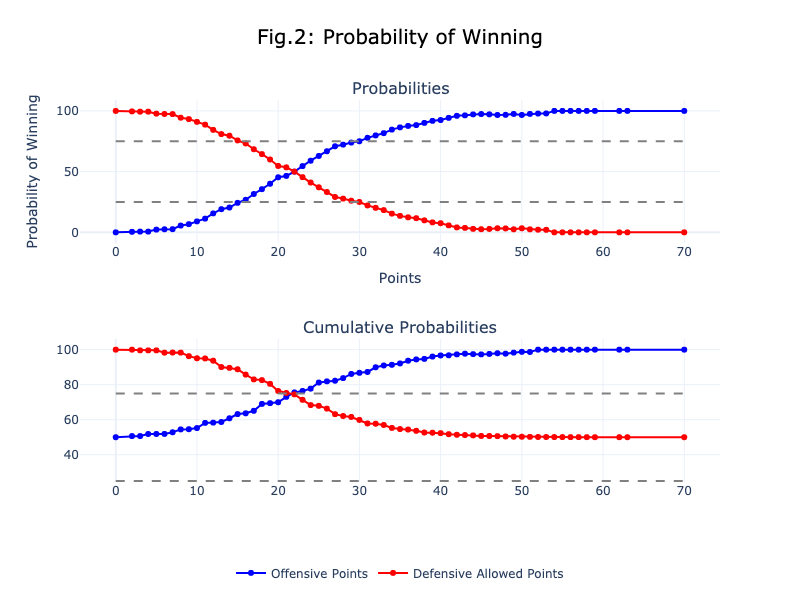

In [23]:
thresholds = sorted(set(nfl_per_game_df["winning_team_score"].unique()) | set(nfl_per_game_df["losing_team_score"].unique()))
bin = 2

off_higher_prob, off_higher_cum_prob, def_lower_prob, def_lower_cum_prob = [], [], [], []
for threshold in thresholds:
    # Offense
    off_higher_wins = len(nfl_per_game_df[
      (nfl_per_game_df["winning_team_score"] >= threshold - bin) & (nfl_per_game_df["winning_team_score"] < threshold + bin)
    ])
    off_higher_losses = len(nfl_per_game_df[
      (nfl_per_game_df["losing_team_score"] >= threshold - bin) & (nfl_per_game_df["losing_team_score"] < threshold + bin)
    ])
    off_higher_cases = off_higher_wins + off_higher_losses
    off_higher_prob.append(off_higher_wins * 100 / off_higher_cases if off_higher_cases > 0 else 0)
    # Cumulative
    off_higher_cum_wins = len(nfl_per_game_df[(nfl_per_game_df["winning_team_score"] >= threshold)])
    off_higher_cum_losses = len(nfl_per_game_df[(nfl_per_game_df["losing_team_score"] >= threshold)])
    off_higher_cum_cases = off_higher_cum_wins + off_higher_cum_losses
    off_higher_cum_prob.append(off_higher_cum_wins * 100 / off_higher_cum_cases if off_higher_cum_cases > 0 else 0)
    # Defense
    def_lower_wins = len(nfl_per_game_df[
      (nfl_per_game_df["losing_team_score"] >= threshold - bin) & (nfl_per_game_df["losing_team_score"] < threshold + bin)
    ])
    def_lower_loss = len(nfl_per_game_df[
      (nfl_per_game_df["winning_team_score"] >= threshold - bin) & (nfl_per_game_df["winning_team_score"] < threshold + bin)
    ])
    def_lower_cases = def_lower_wins + def_lower_loss
    def_lower_prob.append(def_lower_wins * 100 / def_lower_cases if def_lower_cases > 0 else 0)
    # Cumulative
    def_lower_cum_wins = len(nfl_per_game_df[(nfl_per_game_df["losing_team_score"] <= threshold)])
    def_lower_cum_loss = len(nfl_per_game_df[nfl_per_game_df["winning_team_score"] <= threshold])
    def_lower_cum_cases = def_lower_cum_wins + def_lower_cum_loss
    def_lower_cum_prob.append(def_lower_cum_wins * 100 / def_lower_cum_cases if def_lower_cum_cases > 0 else 0)

cumulative_prob_df = pd.DataFrame({
    "Threshold": thresholds,
    "off_higher_prob": off_higher_prob,
    "def_lower_prob": def_lower_prob,
    "off_higher_cum_prob": off_higher_cum_prob,
    "def_lower_cum_prob": def_lower_cum_prob
})

fig = make_subplots(rows=2, cols=1, subplot_titles=("Probabilities", "Cumulative Probabilities"))
fig.add_traces([
    go.Scatter(x=cumulative_prob_df["Threshold"], y=cumulative_prob_df["off_higher_prob"], mode="lines+markers", name="Offensive Points", line=dict(color="blue")),
    go.Scatter(x=cumulative_prob_df["Threshold"], y=cumulative_prob_df["def_lower_prob"], mode="lines+markers", name="Defensive Allowed Points", line=dict(color="red")),
    go.Scatter(x=cumulative_prob_df["Threshold"], y=cumulative_prob_df["off_higher_cum_prob"], mode="lines+markers", name="Offensive Cumulative", line=dict(color="blue"), showlegend=False),
    go.Scatter(x=cumulative_prob_df["Threshold"], y=cumulative_prob_df["def_lower_cum_prob"], mode="lines+markers", name="Defensive Allowed Points", line=dict(color="red"), showlegend=False)
], rows=[1, 1, 2, 2], cols=[1, 1, 1, 1])

for row in (1, 2):
    for y in (25, 75):
        fig.add_shape(type="line", x0=thresholds[0], x1=thresholds[-1], y0=y, y1=y, line=dict(color="gray", dash="dash"), col=1, row=row)

fig.update_layout(
    title=dict(text="Fig.2: Probability of Winning", x=0.5, y=0.95, font=dict(size=20, color="black")),
    xaxis=dict(title="Points", showgrid=True),
    yaxis=dict(title="Probability of Winning", showgrid=True),
    template="plotly_white",
    showlegend=True,
    legend=dict(orientation="h", yanchor="top", y=-0.2, xanchor="center", x=0.5)
)

fig.show()

On *Fig. 2*, we can see the probability of a team winning based on its offensive points or defensive points allowed, for both each value and the cumulative. Here it is interesting to highlight that if **you score exactly 22 points or allow 22 points, you have a 50% chance of winning**. Additionally, teams scoring **22 or more have a 75% chance of winning**, and teams allowing **22 or fewer points have a 75% chance of winning**.

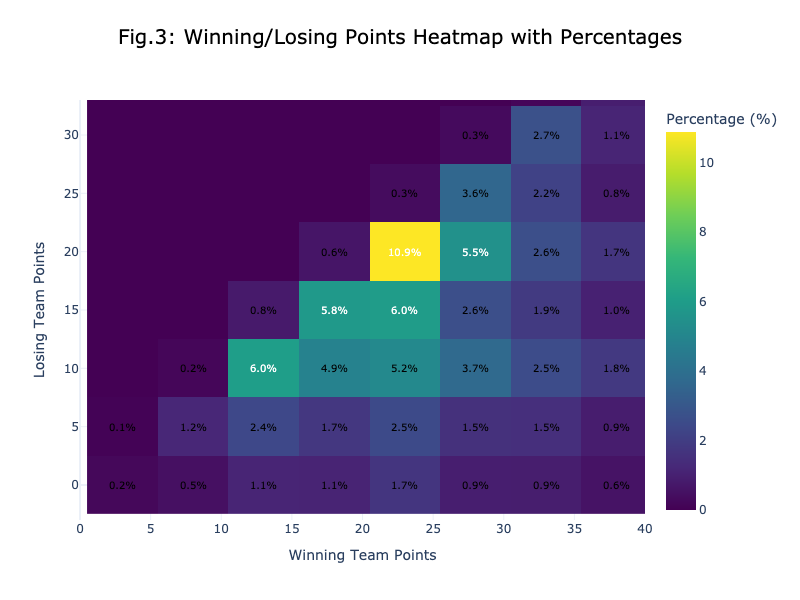

In [24]:
# HeatMap 2D Histogram
RANGE_SIZE = 5
x_bins = np.arange(nfl_per_game_df["winning_team_score"].min(), nfl_per_game_df["winning_team_score"].max() + 1, RANGE_SIZE)
y_bins = np.arange(nfl_per_game_df["losing_team_score"].min(), nfl_per_game_df["losing_team_score"].max() + 1, RANGE_SIZE)
hist, x_edges, y_edges = np.histogram2d(
    nfl_per_game_df["winning_team_score"], nfl_per_game_df["losing_team_score"], bins=[x_bins, y_bins]
)

# Normalize histogram to percentages
hist_percentage = hist / hist.sum() * 100

# Create the heatmap
heatmap = go.Heatmap(
    z=hist_percentage.T,  # Use normalized histogram
    x=x_bins[:-1],
    y=y_bins[:-1],
    colorscale="Viridis",
    colorbar=dict(title="Percentage (%)")
)

# Annotate the heatmap with percentages
annotations = []
for i, y in enumerate(y_bins[:-1]):
    for j, x in enumerate(x_bins[:-1]):
        value = hist_percentage[j, i]
        if value > 0:
            annotations.append(
                go.layout.Annotation(
                    text=f"{value:.1f}%",  # Display percentage with 1 decimal
                    x=x,
                    y=y,
                    showarrow=False,
                    font=dict(size=10, color="white" if value > hist_percentage.max() / 2 else "black")
                )
            )

# Build the figure
fig = go.Figure(data=[heatmap])
fig.update_layout(
    title=dict(text="Fig.3: Winning/Losing Points Heatmap with Percentages", x=0.5, y=0.95, font=dict(size=20, color="black")),
    xaxis=dict(title="Winning Team Points", range=[0, 40]),
    yaxis=dict(title="Losing Team Points", range=[-3, 33]),
    annotations=annotations,  # Add percentage annotations
    template="plotly_white",
)

# Show plot
fig.show()

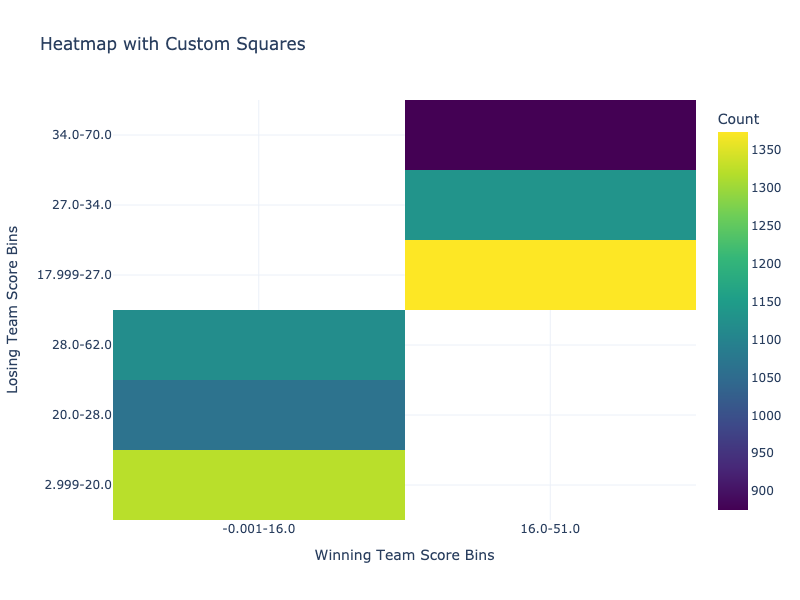

In [54]:
total = len(nfl_per_game_df["winning_team_score"])
edges = qcut_2d(nfl_per_game_df, "losing_team_score", "winning_team_score" , qx=2, qy=3)

# for x_bin, y_bin in edges:
#   print(f"Losing Interval={x_bin[0]}, Losing Interval={y_bin[0]}, Count: {y_bin[1]}, %={int(y_bin[1]/total*100)}%")

results = []
x_labels, y_labels = [], []

for x_bin, y_bin in edges:
    results.append(y_bin[1])
    x_labels.append(f"{x_bin[0].left}-{x_bin[0].right}")
    y_labels.append(f"{y_bin[0].left}-{y_bin[0].right}")

fig = go.Figure(data=[go.Heatmap(z=results, x=x_labels, y=y_labels, colorscale="RdBu", reversescale=True, colorbar=dict(title="Count"))])
fig.update_layout(
    title="Heatmap with Custom Squares",
    xaxis=dict(title="Winning Team Score Bins"),
    yaxis=dict(title="Losing Team Score Bins"),
    template="plotly_white"
)
fig.show()

# Graph
heatmap = go.Heatmap(
    z=hist.T, x=[f"{x_bins[i]}-{x_bins[i+1]}" for i in range(len(x_bins)-1)], y=y_bins[:-1], colorscale="RdBu", reversescale=True, colorbar=dict(title="Frequency")
)
annotations = [
    dict(x=f"{x_bins[i]}-{x_bins[i+1]}", y=y_bins[j], text=f"{hist_percentages[i, j]:.1f}%", showarrow=False, font=dict(size=10, color="black")) for i in range(len(x_bins)-1) for j in range(len(y_bins)-1) if hist_percentages[i, j] > 0
]
fig = go.Figure(data=[heatmap])
fig.update_layout(
    title=dict(text="Fig.6: HeatMap of Spread and Winning Score", x=0.5, y=0.95, font=dict(size=20, color="black")), xaxis=dict(title="Point Spreads"), yaxis=dict(title="Winning Score", tickvals=y_bins), template="plotly_white", annotations=annotations
)


On *Fig. 3*, we can see a heatmap of winning team points versus losing team points. It highlights that the range (23–28) for winning teams versus (20–25) for losing teams is the most common occurrence, with over 10% of scores being in that range. Additionally, the most frequent scores are 23–20 (130 occurrences), 20–17 (128 occurrences), and 27–24 (120 occurrences). We can see a pattern that maybe closed games tend to be more common? Let's take a look to the spread.

### Scores and the Spread

According to [ESPN's Sport Betting](https://www.espn.com/espn/betting/story/_/id/38897025/sports-betting-glossary-odds-lines-spreads-futures-more):
* **Point Spread**: ESPN defines the point spread as the number of points by which the favored team is expected to win over the underdog. Bettors wager on whether the favorite will win by more than the spread or if the underdog will lose by less than the spread or win outright.
* **Total (Over/Under)**: The total is the expected combined point total of both teams in a game. Bettors can wager on whether the actual combined score will be over or under this set number.

So, in simple terms, the spread is the difference between the winning team’s score and the losing team’s score, while the total is the combined score of both teams.

<div style="text-align: center;">
  <figure>
    <img src="article_assets/nfl_spreads.jpg" alt="Spreads" style="max-height: 600px;">
    <figcaption>Cooper Neill | Credit: Getty Images</figcaption>
  </figure>
</div>


Let's do a similar analysis and first take to the distribution of the totals.

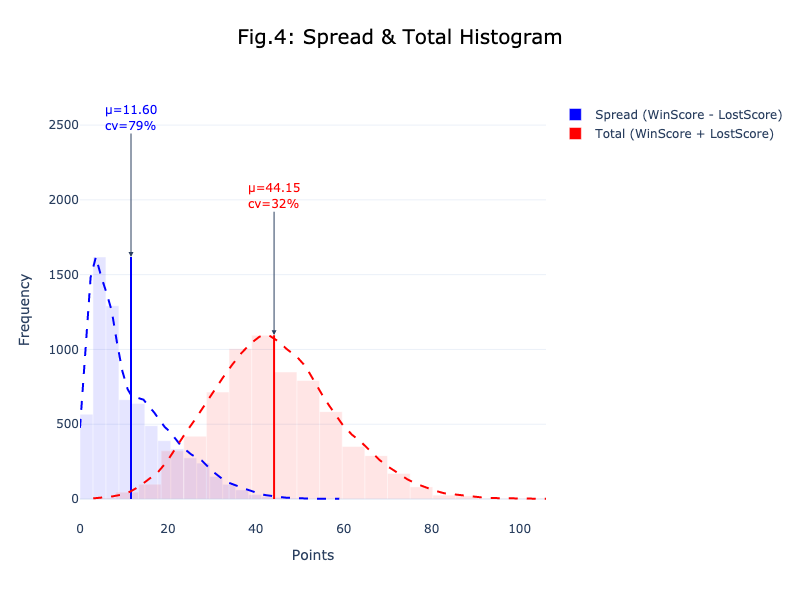

In [26]:
# Figure
HIST_BINS = 20
fig = go.Figure()
plot_overlap_histogram(nfl_per_game_df["score_diff"], fig, bins=HIST_BINS, name="Spread (WinScore - LostScore)", color="blue")
plot_overlap_histogram(nfl_per_game_df["score_total"], fig, bins=HIST_BINS, name="Total (WinScore + LostScore)",color="red")
# Update layout
fig.update_layout(
    title=dict(text="Fig.4: Spread & Total Histogram", x=0.5, y=0.95, font=dict(size=20, color="black")),
    xaxis=dict( title="Points"),
    yaxis_title="Frequency",
    template="plotly_white",
    barmode="overlay"
)
# fig.write_image("figure1.png")
fig.show()

In [27]:
lower_bound=3
higher_bound=8
total = nfl_per_game_df["score_diff"].count()
between_bound = nfl_per_game_df[
    (nfl_per_game_df["score_diff"] >= lower_bound) &
    (nfl_per_game_df["score_diff"] <= higher_bound)
]["score_diff"].count()

print("min_score_diff:", nfl_per_game_df["score_diff"].min(), "max_score_diff:",nfl_per_game_df["score_diff"].max())

print(f"Probabily of score_diff between [{lower_bound}, {higher_bound}]: {round(100*between_bound/total, 2)}")

min_score_diff: 0.0 max_score_diff: 59.0
Probabily of score_diff between [3, 8]: 42.27


As we see in *Fig. 4*, spreads are highly dispersed, ranging from 0 points to 59 points. Notably, there is a high concentration between 3 and 8 points, with 42% of games having a spread within this range. Now let's trade to equally divide the spread.

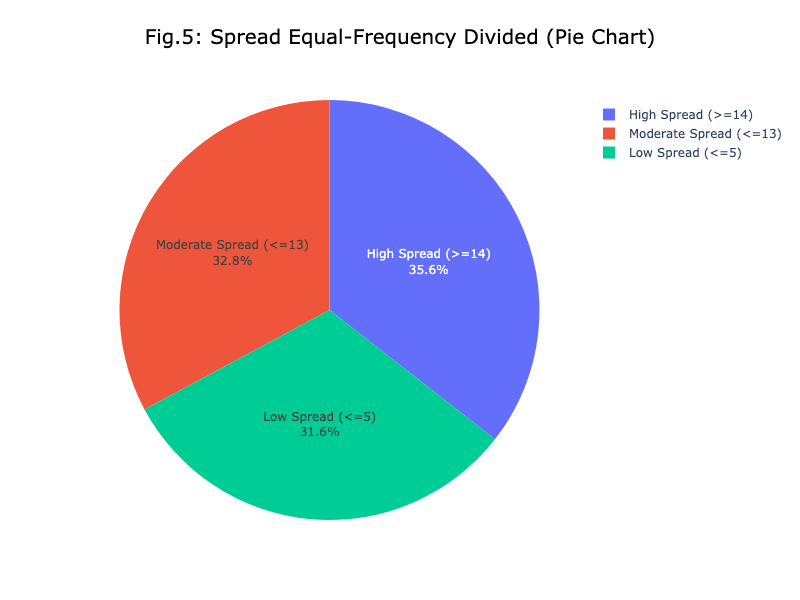

In [28]:
num_bins = 3
data = nfl_per_game_df['score_diff'].reset_index()
win_bin_edges = [0, 5, 13, 60]
data['score_diff_bin'] = pd.cut(
    data['score_diff'], bins=win_bin_edges, labels=["Low Spread (<=5)", "Moderate Spread (<=13)", "High Spread (>=14)"]
)
bin_counts = data['score_diff_bin'].value_counts(sort=False)

fig = go.Figure(go.Pie(
    labels=[str(interval) for interval in bin_counts.index],
    values=bin_counts.values,
    textinfo='percent+label',
    hoverinfo='label+value'
))
fig.update_layout(
    title=dict(text="Fig.5: Spread Equal-Frequency Divided (Pie Chart)", x=0.5, y=0.95, font=dict(size=20, color="black")),
    template="plotly_white"
)
fig.show()

Then, **games are equally divided into 3 spread groups: close-spread, moderate-spread, and high-spread games**:
* **Close Spread**: Where the score difference is between 0-5 points.
* **Moderate Spread**: Where the score difference is between 6-13 points.
* **High Spread**: Where the score difference is higher than 14 points.

Now, let's check how the winning teams are distributed among these spread buckets.

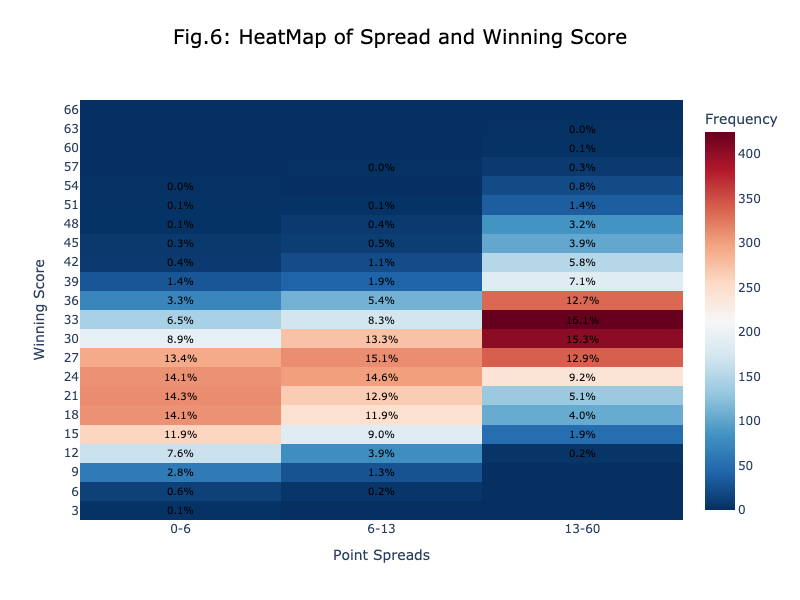

In [29]:
# Data
score_diff_bins = [0, 6, 13, 60]
filtered_df = nfl_per_game_df[(nfl_per_game_df["score_diff"] >= 0) & (nfl_per_game_df["score_diff"] <= 60)]
x_bins = np.array(score_diff_bins)
y_bins = np.arange(filtered_df["winning_team_score"].min(), filtered_df["winning_team_score"].max() + 1, 3)
hist, x_edges, y_edges = np.histogram2d(filtered_df["score_diff"], filtered_df["winning_team_score"], bins=[x_bins, y_bins])
x_bin_totals = hist.sum(axis=1, keepdims=True)
hist_percentages = np.divide(hist, x_bin_totals, where=x_bin_totals != 0) * 100

# Graph
heatmap = go.Heatmap(
    z=hist.T, x=[f"{x_bins[i]}-{x_bins[i+1]}" for i in range(len(x_bins)-1)], y=y_bins[:-1], colorscale="RdBu", reversescale=True, colorbar=dict(title="Frequency")
)
annotations = [
    dict(x=f"{x_bins[i]}-{x_bins[i+1]}", y=y_bins[j], text=f"{hist_percentages[i, j]:.1f}%", showarrow=False, font=dict(size=10, color="black")) for i in range(len(x_bins)-1) for j in range(len(y_bins)-1) if hist_percentages[i, j] > 0
]
fig = go.Figure(data=[heatmap])
fig.update_layout(
    title=dict(text="Fig.6: HeatMap of Spread and Winning Score", x=0.5, y=0.95, font=dict(size=20, color="black")), xaxis=dict(title="Point Spreads"), yaxis=dict(title="Winning Score", tickvals=y_bins), template="plotly_white", annotations=annotations
)
fig.show()

As **Fig. 6** shows:
* Closed-Spread Games, winning team score has almost 65% chance to be between 17-30, mean of 23.
* Moderate-Spread Games, winning team scores has almost 66% chance to be between 17-30 mean of 25.
* High-Spread Games, winning team scores has almost 60% chance to be between 24-37, mean of 33.

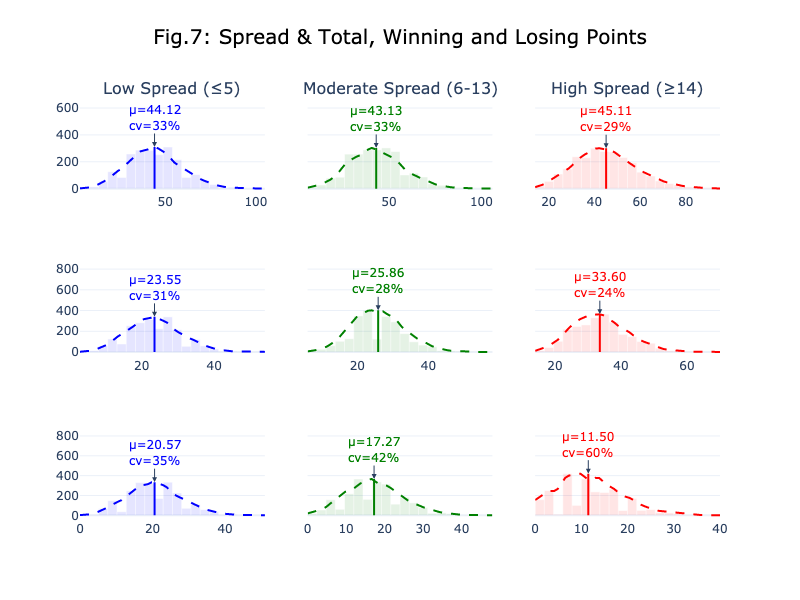

In [30]:
# Figure
nfl_per_game_df_low_spread = nfl_per_game_df[nfl_per_game_df["score_diff"] <= 5]
nfl_per_game_df_moderate_spread = nfl_per_game_df[(nfl_per_game_df["score_diff"] >= 6) & (nfl_per_game_df["score_diff"] <= 13)]
nfl_per_game_df_high_spread = nfl_per_game_df[nfl_per_game_df["score_diff"] >=14]

# Create subplots
fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=("Low Spread (≤5)", "Moderate Spread (6-13)", "High Spread (≥14)"),
    shared_yaxes=True
)

# Plot histograms using the custom function
# def plot_overlap_histogram(data, figure, name, bins=25, color="blue", row=None, col=None):
plot_overlap_histogram(nfl_per_game_df_low_spread["score_total"], fig, bins=HIST_BINS, name="Low Spread", color="blue", row=1, col=1, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_moderate_spread["score_total"], fig, bins=HIST_BINS, name="Medium Spread", color="green", row=1, col=2, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_high_spread["score_total"], fig, bins=HIST_BINS, name="High Spread", color="red", row=1, col=3, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_low_spread["winning_team_score"], fig, bins=HIST_BINS, name="Low Spread", color="blue", row=2, col=1, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_moderate_spread["winning_team_score"], fig, bins=HIST_BINS, name="Medium Spread", color="green", row=2, col=2, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_high_spread["winning_team_score"], fig, bins=HIST_BINS, name="High Spread", color="red", row=2, col=3, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_low_spread["losing_team_score"], fig, bins=HIST_BINS, name="Low Spread", color="blue", row=3, col=1, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_moderate_spread["losing_team_score"], fig, bins=HIST_BINS, name="Medium Spread", color="green", row=3, col=2, ay=-30, max_row=3)
plot_overlap_histogram(nfl_per_game_df_high_spread["losing_team_score"], fig, bins=HIST_BINS, name="High Spread", color="red", row=3, col=3, ay=-30, max_row=3)

# Update layout
fig.update_layout(
    title=dict(text="Fig.7: Spread & Total, Winning and Losing Points", x=0.5, y=0.95, font=dict(size=20, color="black")),
    template="plotly_white",
    showlegend=False
)

fig.show()

## Scores and the Time

## Type of Game bc Scores

## Scores predicting Scores

### How Do You Make Points?

Teams can score points through several methods:
* Touchdown (6 points).
* Extra Point (1 point)
* Two-Point Conversion (2 points)
* Field Goal (3 points)
* Safety (2 points)

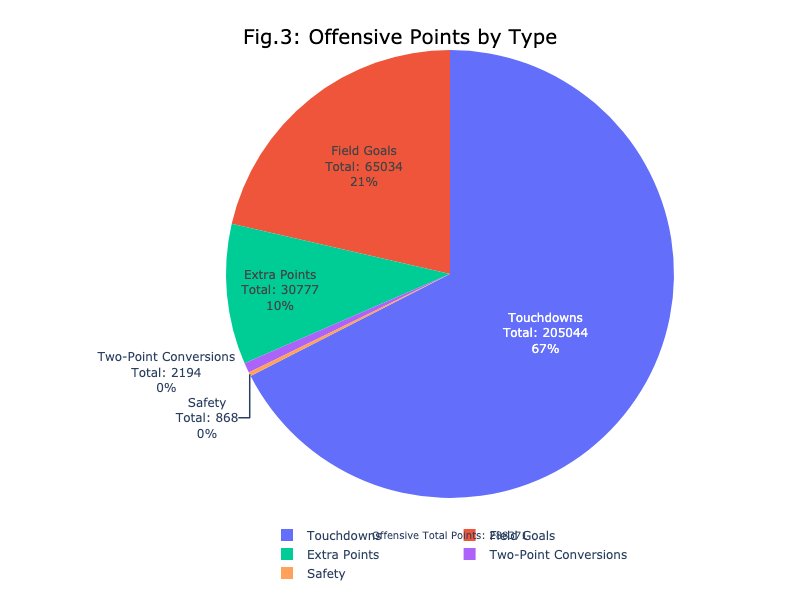

In [31]:
filtered_sum = nfl_per_game_per_team_df[["touchdown", "extra_point_count", "two_point_conv_count", "field_goal_count", "posteam_score_play_diff", "safety"]].sum()
adjusted_values = {
    "Touchdowns": 6 * filtered_sum["touchdown"],
    "Extra Points": filtered_sum["extra_point_count"],
    "Two-Point Conversions": 2* filtered_sum["two_point_conv_count"],
    "Field Goals": 3*filtered_sum["field_goal_count"],
    "Safety": 2*filtered_sum["safety"],
}
labels = list(adjusted_values.keys())
values = list(adjusted_values.values())
percentages = [f"{int(v* 100 / sum(values)) }%" for v in values]
total = filtered_sum["posteam_score_play_diff"]

# Figure
custom_text = [f"{labels[i]}<br>Total: {int(values[i])}<br>{percentages[i]}"for i in range(len(values))]
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    text=custom_text,  # Custom annotations inside the pie
    textinfo="text",   # Show custom text instead of default
    hoverinfo="label+percent+value"  # Show label, percent, and value on hover
)])
fig.update_layout(
    title=dict(text="Fig.3: Offensive Points by Type", x=0.5, y=0.95, font=dict(size=20, color="black")),
    annotations=[
        dict(
            x=0.5, y=-0.1,  # Annotation position
            text=f"Offensive Total Points: {int(total)}",
            showarrow=False,
            font=dict(size=10),
            align="center",
        )
    ],
    margin=dict(t=50, b=50) ,
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",  # Aligns the top of the legend
        y=-0.2,  # Places the legend below the chart
        xanchor="center",  # Centers the legend
        x=0.5  # Centers the legend horizontally
    )
)
fig.show()

In [32]:
absolute_corr = (
    nfl_per_game_per_team_df.corr()["posteam_score_play_diff"]
    .abs()
    .sort_values(ascending=False)
)
absolute_corr

/var/folders/cf/dh24jd9d5dg2grz6xlnygf_c0000gp/T/ipykernel_35342/3721691671.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



posteam_score_play_diff    1.000000
posteam_score_post         0.966332
touchdown                  0.875614
extra_point_count          0.840058
score_differential_post    0.685662
score_total                0.682251
yards_gained               0.680830
pass_touchdown             0.679944
losing_team_score          0.576874
winning_team_score         0.562303
rush_touchdown             0.541567
third_down_failed          0.453317
receiving_yards            0.439988
passing_yards              0.439720
first_down_pass            0.418838
first_down_rush            0.418216
rushing_yards              0.399096
rush_attempt               0.392122
sack                       0.325124
third_down_converted       0.324348
fourth_down_failed         0.316519
interception               0.285199
incomplete_pass            0.267073
yards_after_catch          0.239008
field_goal_count           0.198117
first_down_penalty         0.136964
two_point_conv_count       0.111360
defteam_score_play_diff    0

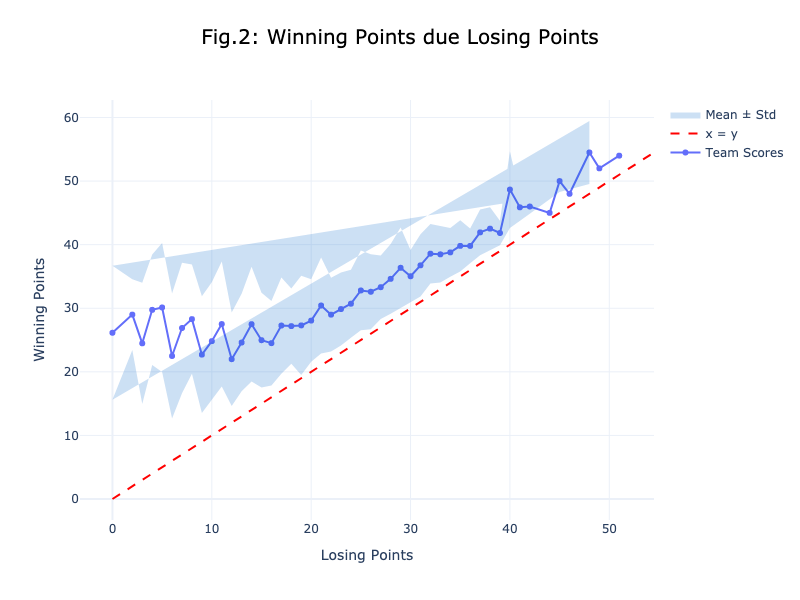

In [33]:
# Group by abs_score_differential_post and calculate average winning_team_score
grouped_data = nfl_per_game_df.groupby("losing_team_score").agg(
    avg_winning_team_score=("winning_team_score", "mean"),
    std_winning_team_score=("winning_team_score", "std")
).reset_index()

# Create scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=grouped_data["losing_team_score"],
    y=grouped_data["avg_winning_team_score"],
    mode="lines+markers",
    name="Team Scores"
))

# Add x=y line
min_val = min(grouped_data["losing_team_score"].min(), grouped_data["avg_winning_team_score"].min())
max_val = max(grouped_data['losing_team_score'].max(), grouped_data['avg_winning_team_score'].max())
fig.add_trace(go.Scatter(
    x=[min_val, max_val],
    y=[min_val, max_val],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='x = y'
))

# Group by abs_score_differential_post and calculate average winning_team_score
# Calculate bounds for the shaded region
grouped_data['lower_bound'] = grouped_data['avg_winning_team_score'] - grouped_data['std_winning_team_score']
grouped_data['upper_bound'] = grouped_data['avg_winning_team_score'] + grouped_data['std_winning_team_score']
# Add shaded area for mean ± std
fig.add_trace(go.Scatter(
    x=grouped_data['losing_team_score'],
    y=grouped_data['upper_bound'],
    mode='lines',
    line=dict(width=0, color='rgba(0,100,200,0.2)'),  # Transparent upper bound
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=grouped_data['losing_team_score'],
    y=grouped_data['lower_bound'],
    mode='lines',
    line=dict(width=0, color='rgba(0,100,200,0.2)'),  # Transparent lower bound
    fill='tonexty',  # Fill area between lower and upper bounds
    fillcolor='rgba(0,100,200,0.2)',
    showlegend=True,
    name='Mean ± Std'
))
# Plot
fig.update_layout(
    title=dict(text="Fig.2: Winning Points due Losing Points", x=0.5, y=0.95, font=dict(size=20, color="black")),
    xaxis_title="Losing Points",
    yaxis_title="Winning Points",
    template="plotly_white"
)
fig.show()

In [34]:
nfl_per_game_per_team_per_wp = (
    nfl_df[ nfl_df['posteam'] != '']
    .groupby([
        'game_id', 'posteam', 'wp',
    ])
    .agg({
        'epa': 'mean',
    })
    .reset_index()
)

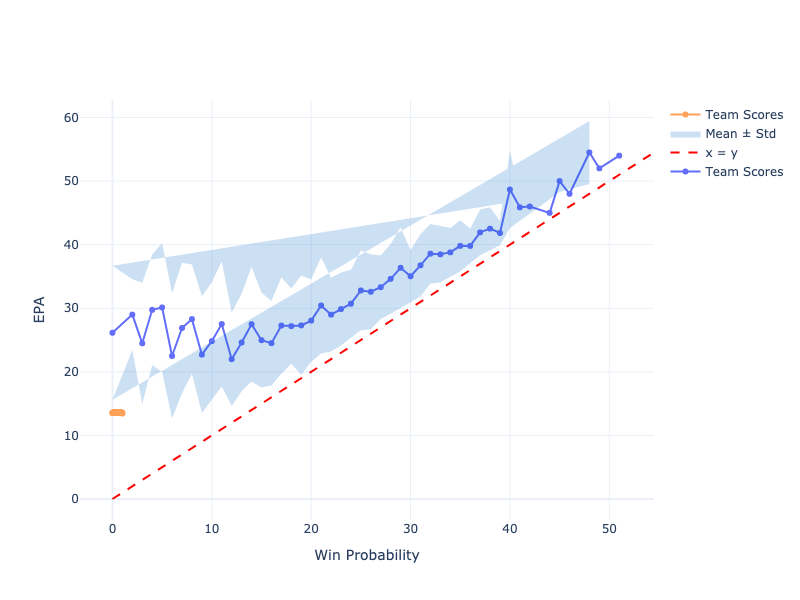

In [35]:

# Group by abs_score_differential_post and calculate average winning_team_score
nfl_per_game_per_team_per_wp['wp_bin'] = (nfl_per_game_per_team_per_wp['wp'] * 100).round() /100
nfl_per_game_per_team_per_wp['abs_epa'] = nfl_per_game_per_team_per_wp['epa'] + abs(min(nfl_per_game_per_team_per_wp['epa']))
grouped_data = nfl_per_game_per_team_per_wp.groupby('wp_bin').agg(
    avg_abs_epa=('abs_epa', 'mean')
).reset_index()


fig.add_trace(go.Scatter(
    x=grouped_data['wp_bin'],
    y=grouped_data['avg_abs_epa'],
    mode='lines+markers',
    name='Team Scores'
))

# Update layout
fig.update_layout(
    title="",
    xaxis_title="Win Probability",
    yaxis_title="EPA",
    template="plotly_white"
)
# Show the plot
fig.show()

## Cooking 🧑‍🍳
---


## Credits
---
* Assistants: Since content, images,

---
## To be continued ...